In [1]:
import os

def get_repo_dir():
    cwd = os.getcwd()
    splited = cwd.split('/')
    ind = splited.index('fsCounter')
    repo_dir = '/'
    for s in splited[1:ind + 1]:
        repo_dir = os.path.join(repo_dir, s)

    return repo_dir

In [2]:
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display



sys.path.append(get_repo_dir())

from vision.tools.jupyter_notebooks.notebook_analysis_help_funcs import *
from vision.tools.post_process_analysis import read_tracks_and_slices, get_block_count
from vision.visualization.draw_bb_from_csv import draw_tree_bb_from_tracks

In [3]:
def concat_to_meta(block_meta, df):
    df_col = list(block_meta.columns)
    new_data = []
    data = block_meta.copy()
    for id_, sample in data.iterrows():
        block = sample['block'].lower()
        row = sample['row'].lower()
        tree_id = int(sample['tree_id'])
        q_data = df.query(f'block == "{block}" and row == "{row}" and tree_id == {tree_id}')
        new_sample = sample.to_list()
        for i in range(1, 4):
            new_sample.append(q_data[str(i)].values[0])
        new_data.append(new_sample)

    df_col += ['cv1', 'cv2', 'cv3']
    new_df = pd.DataFrame(new_data, columns=df_col)

    return new_df

def add_ratios(df):
    df['F/cv1'] = df['F'] / df['cv1']
    df['F/cv2'] = df['F'] / df['cv2']
    df['F/cv3'] = df['F'] / df['cv3']

    return df

def get_block_ratio(block_df, row_tracks, y_threshold=800, depth=3):
    block_col = list(block_df.columns)
    new_data = []
    for id_, sample in block_df.iterrows():
        row = sample['row'].lower()
        tree_id = int(sample['tree_id'])
        tree_df = row_tracks[row][tree_id]

        d_tree_df = tree_df.query(f'depth <= {depth}')
        
        
        lower_tree_df = tree_df.query(f'y1 > {y_threshold} and depth <= {depth}')
        count = len(tree_df.track_id.unique())
        lower_count = len(lower_tree_df.track_id.unique())
        ratio = lower_count / count

        gdf = lower_tree_df.groupby('track_id')
        lower_tracks_depth = np.array(gdf.depth.mean())
        filtered_lower_tracks_depth = lower_tracks_depth[lower_tracks_depth < 3]
        mean = np.mean(filtered_lower_tracks_depth)
        std = np.std(filtered_lower_tracks_depth)          
        
        new_sample = sample.to_list()
 
        uniq, counts = np.unique(d_tree_df["track_id"], return_counts=True)
        for i in range(0, 5):
            new_sample.append(len(uniq[counts>i]))
            
        new_data.append(new_sample)

    #block_col += ['y_ratio', 'mean', 'std', 'lcv1', 'lcv2', 'lcv3', 'lcv4', 'lcv5']
    block_col += ['dcv1', 'dcv2', 'dcv3', 'dcv4', 'dcv5']
    new_df = pd.DataFrame(new_data, columns=block_col)

    return new_df    

In [4]:
def linear_model_selection(data, selection_cols=["cv1"], type_col="block", cross_val='row'):

    factors = {}
    for col in selection_cols:
        factor, res_mean, res_std, tree_mean, tree_std, all_preds = run_LROCV(data, cv_col=col, type_col=type_col, cross_val=cross_val, return_res=True)
        factors[col] = {'factor': factor, 'mean_error': res_mean, 'std_error': res_std}

    return factors
    

In [5]:
def block_analysis(block_path, metadata_path, block_):
    block_counts, row_tracks = get_block_count(block_path)
    block_counts_df = pd.DataFrame(block_counts, columns=['tree_id', 'block', 'row', '1', '2','3'])
    meta_data = pd.read_csv(metadata_path)
    block_meta = meta_data.query(f'block == "{block_}"')
    block_df = concat_to_meta(block_meta, block_counts_df)
    block_df['F/cv1'] = block_df['F'] / block_df['cv1'] 
    block_df = get_block_ratio(block_df, row_tracks)

    return block_df, row_tracks

In [21]:
def get_selection_error(factors_dict, block_df):
    results = {}
    for item_ in list(factors_dict.keys()):
        block_df[f'err_{item_}'] = (block_df['F'] - (block_df[item_] * factors_dict[item_]['factor'])) / block_df['F']
        results[item_] = {'err': np.mean(block_df[f'err_{item_}']), 'err_std': np.std(block_df[f'err_{item_}'])}

    return results, block_df

In [6]:
metadata_path = "/media/matans/My Book/FruitSpec/Apples_SA/data_meta.csv"

In [9]:
block_path = "/media/matans/My Book/FruitSpec/Apples_SA/block_13"
block_ = 'Block_13'
block_13_df, row_tracks_13 = block_analysis(block_path, metadata_path, block_)

In [10]:
block_13_df

,id,block,row,tree,side,tree_id,variety,F,cv1,cv2,cv3,F/cv1,dcv1,dcv2,dcv3,dcv4,dcv5
0,1,Block_13,Row_1111,9,A,2,Royal Beauty,823,973,518,364,0.845838,847,455,308,205,149
1,2,Block_13,Row_1111,10,A,1,Royal Beauty,1007,739,425,290,1.362652,696,390,273,209,160
2,3,Block_13,Row_2222,9,B,1,Royal Beauty,823,965,488,298,0.852850,822,425,249,172,104
3,4,Block_13,Row_2222,10,B,2,Royal Beauty,1007,1047,519,343,0.961796,989,483,315,198,142
4,5,Block_13,Row_3333,11,B,1,Royal Beauty,455,586,229,128,0.776451,508,196,105,73,53
5,6,Block_13,Row_3333,12,B,2,Royal Beauty,637,780,413,285,0.816667,712,390,271,201,159
6,7,Block_13,Row_4444,12,A,1,Royal Beauty,637,937,500,357,0.679829,821,435,309,236,167
7,8,Block_13,Row_4444,11,A,2,Royal Beauty,455,511,247,171,0.890411,439,215,142,111,77
8,9,Block_13,Row_5555,14,A,1,Early_red_one,1008,1159,799,648,0.869715,1096,745,595,454,366
9,10,Block_13,Row_5555,13,A,2,Early_red_one,1440,1814,1199,960,0.793826,1729,1150,908,720,585


In [9]:
#row_to_drow = 'row_8888'
#tree_id = 2
#draw_tree_bb_from_tracks(row_tracks[row_to_drow][tree_id], os.path.join(block_path, row_to_drow, '1'), tree_id)

Text(0, 0.5, 'F/CV1')

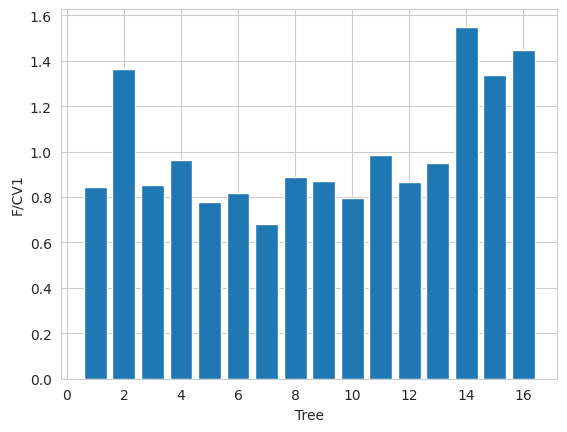

In [10]:
plt.bar(block_13_df['id'], block_13_df['F/cv1'])
plt.xlabel('Tree')
plt.ylabel('F/CV1')

/home/matans/miniconda3/envs/fsCounter/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1000x600 with 0 Axes>

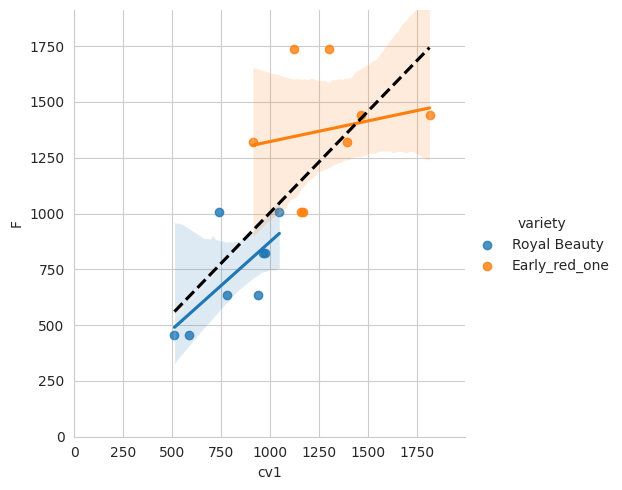

In [11]:
plot_F_cv(block_13_df, 1, hue='variety', add_xy_line=False)

/home/matans/miniconda3/envs/fsCounter/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1000x600 with 0 Axes>

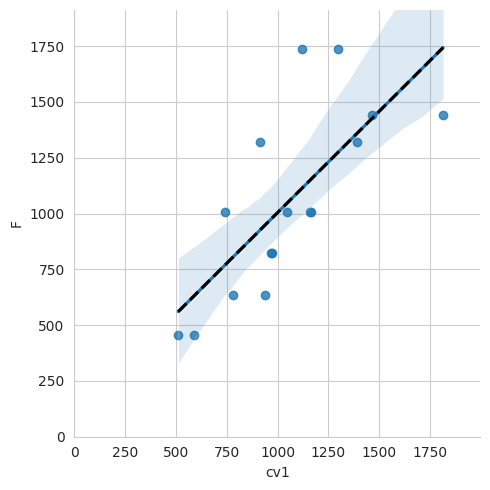

In [12]:
plot_F_cv(block_13_df, 1, add_xy_line=False)

In [13]:
factors_dict = linear_model_selection(block_13_df, selection_cols=['cv1','dcv1', 'cv3', 'dcv3'],type_col="block", cross_val='id')

true: 1319,    pred: 884.8299041168156. (32.92 %) (16)
true: 1738,    pred: 1244.3508042109831. (28.40 %) (15)
true: 1738,    pred: 1068.331464230948. (38.53 %) (14)
true: 1319,    pred: 1385.9840912846516. (5.08 %) (13)
true: 1008,    pred: 1167.3469071142258. (15.81 %) (12)
true: 1440,    pred: 1453.1588131143185. (0.91 %) (11)
true: 1440,    pred: 1871.8096729988156. (29.99 %) (10)
true: 1008,    pred: 1159.7476504849442. (15.05 %) (9)
true: 455,    pred: 507.4134465515467. (11.52 %) (8)
true: 637,    pred: 942.9406323486259. (48.03 %) (7)
true: 637,    pred: 777.8566473303844. (22.11 %) (6)
true: 455,    pred: 583.3457786847715. (28.21 %) (5)
true: 1007,    pred: 1040.0736246670854. (3.28 %) (4)
true: 823,    pred: 963.6300411258026. (17.09 %) (3)
true: 1007,    pred: 724.8759261213158. (28.02 %) (2)
true: 823,    pred: 972.0864825707442. (18.12 %) (1)
0.2144148458256939 0.12652466227636172
(0.2144148458256939, 0.12652466227636172)
[0.99160457]
true: 1319,    pred: 884.829904116815

In [15]:
factors_dict

{'cv1': {'factor': array([0.99906113]),
  'mean_error': 0.2144148458256939,
  'std_error': 0.12652466227636172},
 'dcv1': {'factor': array([1.09377003]),
  'mean_error': 0.2033347454571638,
  'std_error': 0.13099617953690934},
 'cv3': {'factor': array([2.00935114]),
  'mean_error': 0.2741728118169738,
  'std_error': 0.11133312408455796},
 'dcv3': {'factor': array([2.20242271]),
  'mean_error': 0.27965816642227304,
  'std_error': 0.13109718983244406}}

In [97]:
block_13_factor_cv1 = 0.9917
block_13_factor_dcv1 = 1.00831
block_13_factor_cv3 = 2.0165
block_13_factor_dcv3 = 2.21416

In [98]:
block_13_df['acc1'] = (block_13_df['F'] - (block_13_df['cv1'] * block_13_factor)) / block_13_df['F']
block_13_df['dacc1'] = (block_13_df['F'] - (block_13_df['dcv1'] * block_13_factor_dcv1)) / block_13_df['F']
block_13_df['acc3'] = (block_13_df['F'] - (block_13_df['cv3'] * block_13_factor_cv3)) / block_13_df['F']
block_13_df['dacc3'] = (block_13_df['F'] - (block_13_df['dcv3'] * block_13_factor_dcv3)) / block_13_df['F']


In [99]:
block_13_df

,id,block,row,tree,side,tree_id,variety,F,cv1,cv2,cv3,dcv1,dcv2,dcv3,dcv4,dcv5,acc1,dacc1,acc3,dacc3
0,1,Block_13,Row_1111,9,A,2,Royal Beauty,823,973,518,364,847,455,308,205,149,-0.172447,-0.037714,0.108134,0.171371
1,2,Block_13,Row_1111,10,A,1,Royal Beauty,1007,739,425,290,696,390,273,209,160,0.272228,0.303095,0.419280,0.399736
2,3,Block_13,Row_2222,9,B,1,Royal Beauty,823,965,488,298,822,425,249,172,104,-0.162807,-0.007085,0.269846,0.330102
3,4,Block_13,Row_2222,10,B,2,Royal Beauty,1007,1047,519,343,989,483,315,198,142,-0.031092,0.009713,0.313148,0.307388
4,5,Block_13,Row_3333,11,B,1,Royal Beauty,455,586,229,128,508,196,105,73,53,-0.277222,-0.125761,0.432721,0.489040
5,6,Block_13,Row_3333,12,B,2,Royal Beauty,637,780,413,285,712,390,271,201,159,-0.214327,-0.127028,0.097798,0.058026
6,7,Block_13,Row_4444,12,A,1,Royal Beauty,637,937,500,357,821,435,309,236,167,-0.458749,-0.299564,-0.130126,-0.074059
7,8,Block_13,Row_4444,11,A,2,Royal Beauty,455,511,247,171,439,215,142,111,77,-0.113755,0.027147,0.242151,0.308987
8,9,Block_13,Row_5555,14,A,1,Early_red_one,1008,1159,799,648,1096,745,595,454,366,-0.140258,-0.096337,-0.296321,-0.306969
9,10,Block_13,Row_5555,13,A,2,Early_red_one,1440,1814,1199,960,1729,1150,908,720,585,-0.249267,-0.210672,-0.344333,-0.396151


In [100]:
block_mean_cv1 = np.mean(block_13_df['acc1'])
block_std_cv1 = np.std(block_13_df['acc1'])
block_mean_dcv1 = np.mean(block_13_df['dacc1'])
block_std_dcv1 = np.std(block_13_df['dacc1'])
block_mean_cv3 = np.mean(block_13_df['acc3'])
block_std_cv3 = np.std(block_13_df['acc3'])
block_mean_dcv3 = np.mean(block_13_df['dacc3'])
block_std_dcv3 = np.std(block_13_df['dacc3'])
print(f'CV1 block ACC: {block_mean_cv1}, block ACC STD: {block_std_cv1}')
print(f'dCV1 block ACC: {block_mean_dcv1}, block ACC STD: {block_std_dcv1}')
print(f'CV3 block ACC: {block_mean_cv3}, block ACC STD: {block_std_cv3}')
print(f'dCV3 block ACC: {block_mean_dcv3}, block ACC STD: {block_std_dcv3}')

CV1 block ACC: -0.0508827097502948, block ACC STD: 0.2288679928031658
dCV1 block ACC: 0.04085765075480906, block ACC STD: 0.20592545018022382
CV3 block ACC: 0.0882947928704549, block ACC STD: 0.2621553797135121
dCV3 block ACC: 0.10615489017385339, block ACC STD: 0.26781185878752706


In [22]:
block_21_path = "/media/matans/My Book/FruitSpec/Apples_SA/block_21/block_21"
block_21 = 'Block_21'
block_21_df, row_tracks_21 = block_analysis(block_21_path, metadata_path, block_21)

In [23]:
block_21_df

,id,block,row,tree,side,tree_id,variety,F,cv1,cv2,cv3,F/cv1,dcv1,dcv2,dcv3,dcv4,dcv5
0,17,Block_21,Row_1111,17,A,1,Sundowner,1404,780,525,406,1.800000,745,488,383,308,237
1,18,Block_21,Row_1111,18,A,2,Sundowner,1508,651,404,307,2.316436,613,381,285,228,175
2,19,Block_21,Row_2222,18,B,1,Sundowner,1508,999,664,524,1.509510,968,635,494,404,332
3,20,Block_21,Row_2222,17,B,2,Sundowner,1404,887,578,426,1.582864,850,554,405,326,245
4,21,Block_21,Row_3333,19,A,1,Sundowner,1475,962,657,534,1.533264,935,629,507,417,360
5,22,Block_21,Row_3333,20,A,2,Sundowner,1781,1287,817,666,1.383838,1240,784,620,505,432
6,23,Block_21,Row_4444,20,B,1,Sundowner,1781,1039,704,546,1.714148,985,661,508,402,312
7,24,Block_21,Row_4444,19,B,2,Sundowner,1475,941,617,479,1.567481,881,587,456,359,295


/home/matans/miniconda3/envs/fsCounter/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1000x600 with 0 Axes>

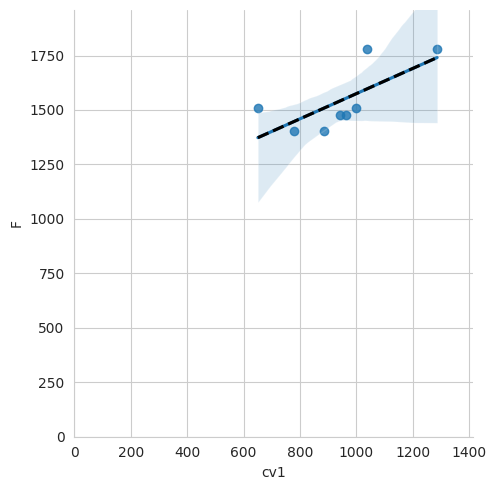

In [25]:
plot_F_cv(block_21_df, 1, add_xy_line=False)

In [27]:
factors_21_dict = linear_model_selection(block_21_df, selection_cols=['cv1','dcv1', 'cv3', 'dcv3'],type_col="block", cross_val='id')

true: 1475,    pred: 1509.2220548430485. (2.32 %) (24)
true: 1781,    pred: 1641.3887479283571. (7.84 %) (23)
true: 1781,    pred: 2139.0672740400773. (20.10 %) (22)
true: 1475,    pred: 1547.8515335159261. (4.94 %) (21)
true: 1404,    pred: 1420.4979000358367. (1.18 %) (20)
true: 1508,    pred: 1611.9669911880462. (6.89 %) (19)
true: 1508,    pred: 1012.756604084879. (32.84 %) (18)
true: 1404,    pred: 1233.504883362697. (12.14 %) (17)
0.1103212788544517 0.09979245724978834
(0.1103212788544517, 0.09979245724978834)
[1.599476]
true: 1475,    pred: 1509.2220548430485. (2.32 %) (24)
true: 1781,    pred: 1641.3887479283571. (7.84 %) (23)
true: 1781,    pred: 2139.0672740400773. (20.10 %) (22)
true: 1475,    pred: 1547.8515335159261. (4.94 %) (21)
true: 1404,    pred: 1420.4979000358367. (1.18 %) (20)
true: 1508,    pred: 1611.9669911880462. (6.89 %) (19)
true: 1508,    pred: 1012.756604084879. (32.84 %) (18)
true: 1404,    pred: 1233.504883362697. (12.14 %) (17)
0.1103212788544517 0.09979

In [18]:
#row_to_drow = 'row_1111'
#tree_id = 1
#draw_tree_bb_from_tracks(row_tracks[row_to_drow][tree_id], os.path.join(block_path, row_to_drow, '1'), tree_id)

In [53]:
block_21_factor_cv1 = 1.599476
block_21_factor_dcv1 = 1.66923088
block_21_factor_cv3 = 3.08106144
block_21_factor_dcv3 = 3.27543787

block_21_df['acc1'] = (block_21_df['F'] - (block_21_df['cv1'] * block_21_factor_cv1)) / block_21_df['F']
block_21_df['dacc1'] = (block_21_df['F'] - (block_21_df['dcv1'] * block_21_factor_dcv1)) / block_21_df['F']
block_21_df['acc3'] = (block_21_df['F'] - (block_21_df['cv3'] * block_21_factor_cv3)) / block_21_df['F']
block_21_df['dacc3'] = (block_21_df['F'] - (block_21_df['dcv3'] * block_21_factor_dcv3)) / block_21_df['F']

block_mean_cv1 = np.mean(block_21_df['acc1'])
block_std_cv1 = np.std(block_21_df['acc1'])
block_mean_dcv1 = np.mean(block_21_df['dacc1'])
block_std_dcv1 = np.std(block_21_df['dacc1'])
block_mean_cv3 = np.mean(block_21_df['acc3'])
block_std_cv3 = np.std(block_21_df['acc3'])
block_mean_dcv3 = np.mean(block_21_df['dacc3'])
block_std_dcv3 = np.std(block_21_df['dacc3'])
print(f'CV1 block ACC: {block_mean_cv1}, block ACC STD: {block_std_cv1}')
print(f'dCV1 block ACC: {block_mean_dcv1}, block ACC STD: {block_std_dcv1}')
print(f'CV3 block ACC: {block_mean_cv3}, block ACC STD: {block_std_cv3}')
print(f'dCV3 block ACC: {block_mean_dcv3}, block ACC STD: {block_std_dcv3}')

CV1 block ACC: 0.02478673780871833, block ACC STD: 0.1313357000146265
dCV1 block ACC: 0.026643730860443922, block ACC STD: 0.13762594044077564
CV3 block ACC: 0.032951164438472375, block ACC STD: 0.1544879280661925
dCV3 block ACC: 0.032081408072883476, block ACC STD: 0.1567650598499716


Text(0, 0.5, 'F/CV1')

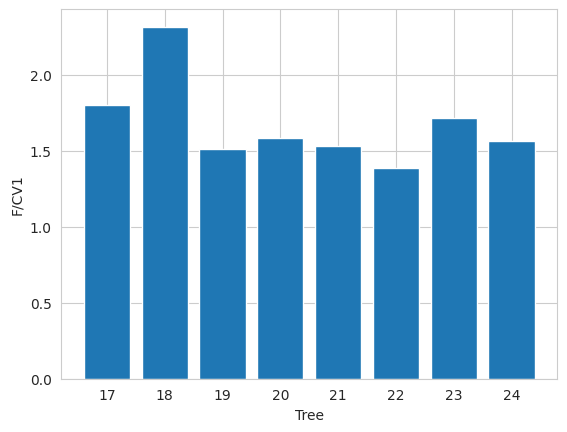

In [54]:
plt.bar(block_21_df['id'], block_21_df['F/cv1'])
plt.xlabel('Tree')
plt.ylabel('F/CV1')

In [42]:
block_48_path = "/media/matans/My Book/FruitSpec/Apples_SA/block_48/block_48"
block_48 = 'Block_48'
block_48_df, row_tracks_48 = block_analysis(block_48_path, metadata_path, block_48)

In [43]:
block_48_df

,id,block,row,tree,side,tree_id,variety,F,cv1,cv2,cv3,F/cv1,dcv1,dcv2,dcv3,dcv4,dcv5
0,25,Block_48,Row_111,25,B,1,Rosy Glow,1077,1474,858,629,0.730665,1323,764,535,399,310
1,26,Block_48,Row_111,26,B,2,Rosy Glow,432,1124,652,450,0.384342,979,567,382,264,201
2,27,Block_48,Row_222,26,A,1,Rosy Glow,432,1611,974,730,0.268156,1305,756,556,398,300
3,28,Block_48,Row_222,25,A,2,Rosy Glow,1077,1531,982,756,0.703462,1441,923,693,520,402
4,29,Block_48,Row_333,27,B,1,Rosy Glow,1376,1296,686,433,1.061728,1203,611,370,257,162
5,30,Block_48,Row_333,28,B,2,Rosy Glow,879,1337,788,591,0.657442,1173,699,523,397,307
6,31,Block_48,Row_444,28,A,1,Rosy Glow,879,1609,908,670,0.546302,1449,811,607,469,378
7,32,Block_48,Row_444,27,A,2,Rosy Glow,1376,1469,946,711,0.936692,1391,891,648,503,395


In [44]:
factors_48_dict = linear_model_selection(block_48_df, selection_cols=['cv1','dcv1', 'cv3', 'dcv3'],type_col="block", cross_val='id')

true: 1376,    pred: 894.8258460717605. (34.97 %) (32)
true: 879,    pred: 1080.0350210849913. (22.87 %) (31)
true: 879,    pred: 870.4673374683285. (0.97 %) (30)
true: 1376,    pred: 784.8090472372261. (42.96 %) (29)
true: 1077,    pred: 984.7983876900619. (8.56 %) (28)
true: 432,    pred: 1164.5729608461886. (169.58 %) (27)
true: 432,    pred: 757.3411016649175. (75.31 %) (26)
true: 1077,    pred: 943.1455562773274. (12.43 %) (25)
0.45956505950873633 0.516630892247933
(0.45956505950873633, 0.516630892247933)
[0.65174777]
true: 1376,    pred: 894.8258460717605. (34.97 %) (32)
true: 879,    pred: 1080.0350210849913. (22.87 %) (31)
true: 879,    pred: 870.4673374683285. (0.97 %) (30)
true: 1376,    pred: 784.8090472372261. (42.96 %) (29)
true: 1077,    pred: 984.7983876900619. (8.56 %) (28)
true: 432,    pred: 1164.5729608461886. (169.58 %) (27)
true: 432,    pred: 757.3411016649175. (75.31 %) (26)
true: 1077,    pred: 943.1455562773274. (12.43 %) (25)
0.45956505950873633 0.516630892247

In [45]:
block_48_df['acc1'] = (block_48_df['F'] - (block_48_df['cv1'] * factors_48_dict['cv1']['factor'])) / block_48_df['F']
block_48_df['dacc1'] = (block_48_df['F'] - (block_48_df['dcv1'] * factors_48_dict['dcv1']['factor'])) / block_48_df['F']
block_48_df['acc3'] = (block_48_df['F'] - (block_48_df['cv3'] * factors_48_dict['cv3']['factor'])) / block_48_df['F']
block_48_df['dacc3'] = (block_48_df['F'] - (block_48_df['dcv3'] * factors_48_dict['dcv3']['factor'])) / block_48_df['F']

block_mean_cv1 = np.mean(block_48_df['acc1'])
block_std_cv1 = np.std(block_48_df['acc1'])
block_mean_dcv1 = np.mean(block_48_df['dacc1'])
block_std_dcv1 = np.std(block_48_df['dacc1'])
block_mean_cv3 = np.mean(block_48_df['acc3'])
block_std_cv3 = np.std(block_48_df['acc3'])
block_mean_dcv3 = np.mean(block_48_df['dacc3'])
block_std_dcv3 = np.std(block_48_df['dacc3'])
print(f'CV1 block ACC: {block_mean_cv1}, block ACC STD: {block_std_cv1}')
print(f'dCV1 block ACC: {block_mean_dcv1}, block ACC STD: {block_std_dcv1}')
print(f'CV3 block ACC: {block_mean_cv3}, block ACC STD: {block_std_cv3}')
print(f'dCV3 block ACC: {block_mean_dcv3}, block ACC STD: {block_std_dcv3}')

CV1 block ACC: -0.15830942430357833, block ACC STD: 0.5561908389619297
dCV1 block ACC: -0.15370381044174491, block ACC STD: 0.4877101537150989
CV3 block ACC: -0.12462849802798263, block ACC STD: 0.5633242934275822
dCV3 block ACC: -0.10834744035067548, block ACC STD: 0.47859813312062466


In [47]:
factors_48_dict

{'cv1': {'factor': array([0.63985452]),
  'mean_error': 0.45956505950873633,
  'std_error': 0.516630892247933},
 'dcv1': {'factor': array([0.72551234]),
  'mean_error': 0.40298841900785487,
  'std_error': 0.4366604287814293},
 'cv3': {'factor': array([1.43186317]),
  'mean_error': 0.4437523111831828,
  'std_error': 0.5417108789046683},
 'dcv3': {'factor': array([1.66141697]),
  'mean_error': 0.40445649534263006,
  'std_error': 0.40677259559254353}}

Text(0, 0.5, 'F/CV1')

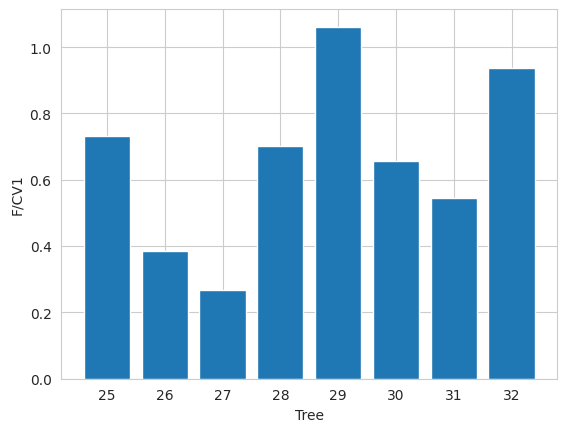

In [48]:
plt.bar(block_48_df['id'], block_48_df['F/cv1'])
plt.xlabel('Tree')
plt.ylabel('F/CV1')

In [12]:
block_3_path = "/media/matans/My Book/FruitSpec/Apples_SA/block_3"
block_3 = 'Block_3'
block_3_df, row_tracks_3 = block_analysis(block_3_path, metadata_path, block_3)

In [13]:
block_3_df

,id,block,row,tree,side,tree_id,variety,F,cv1,cv2,cv3,F/cv1,dcv1,dcv2,dcv3,dcv4,dcv5
0,33,Block_3,Row_111,11,A,1,Royal Beauty,1022,762,523,414,1.341207,731,497,398,330,274
1,34,Block_3,Row_111,16,A,2,Royal Beauty,901,825,538,429,1.092121,756,501,396,335,280
2,35,Block_3,Row_222,16,B,1,Royal Beauty,901,648,432,344,1.390432,613,411,329,277,233
3,36,Block_3,Row_222,11,B,2,Royal Beauty,1022,566,342,260,1.805654,531,328,244,193,144
4,37,Block_3,Row_333,3,B,1,Royal Beauty,1224,1076,653,474,1.137546,1012,608,439,342,274
5,38,Block_3,Row_333,17,A,2,Royal Beauty,788,748,468,375,1.053476,652,409,317,252,204
6,39,Block_3,Row_444,17,B,1,Royal Beauty,788,510,330,264,1.545098,473,313,250,209,169
7,40,Block_3,Row_444,3,A,2,Royal Beauty,1224,820,518,380,1.492683,798,494,368,282,211


In [15]:
factors_3_dict = linear_model_selection(block_3_df, selection_cols=['cv1','dcv1', 'cv3', 'dcv3'],type_col="block", cross_val='id')

true: 1224,    pred: 1028.932287720076. (15.94 %) (40)
true: 788,    pred: 649.7535576193254. (17.54 %) (39)
true: 788,    pred: 988.418510657277. (25.43 %) (38)
true: 1224,    pred: 1441.2359488231539. (17.75 %) (37)
true: 1022,    pred: 708.0559105582537. (30.72 %) (36)
true: 901,    pred: 828.8811286085826. (8.00 %) (35)
true: 901,    pred: 1091.4453026229237. (21.14 %) (34)
true: 1022,    pred: 976.704382699141. (4.43 %) (33)
0.17619349943476253 0.08017460485333146
(0.17619349943476253, 0.08017460485333146)
[1.28918483]
true: 1224,    pred: 1028.932287720076. (15.94 %) (40)
true: 788,    pred: 649.7535576193254. (17.54 %) (39)
true: 788,    pred: 988.418510657277. (25.43 %) (38)
true: 1224,    pred: 1441.2359488231539. (17.75 %) (37)
true: 1022,    pred: 708.0559105582537. (30.72 %) (36)
true: 901,    pred: 828.8811286085826. (8.00 %) (35)
true: 901,    pred: 1091.4453026229237. (21.14 %) (34)
true: 1022,    pred: 976.704382699141. (4.43 %) (33)
0.17619349943476253 0.08017460485333

Text(0, 0.5, 'F/CV1')

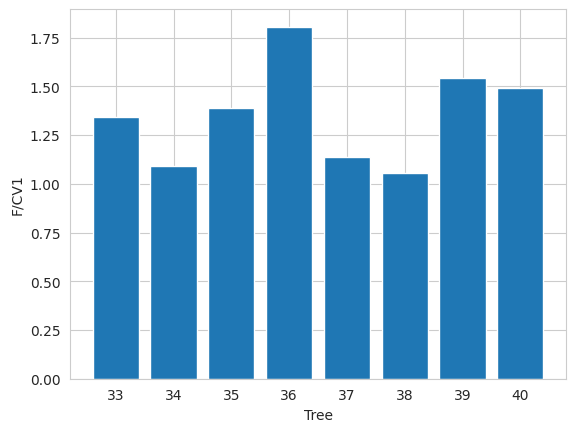

In [16]:
plt.bar(block_3_df['id'], block_3_df['F/cv1'])
plt.xlabel('Tree')
plt.ylabel('F/CV1')

In [22]:
res, block_3_df_res = get_selection_error(factors_3_dict, block_3_df)

In [23]:
res

{'cv1': {'err': 0.025902503033865144, 'err_std': 0.169220056687829},
 'dcv1': {'err': 0.024691161912311226, 'err_std': 0.15148038347837484},
 'cv3': {'err': -0.0004595780037125463, 'err_std': 0.19102913714469022},
 'dcv3': {'err': -0.006982206559886229, 'err_std': 0.17092696939802896}}

In [24]:
block_3_df_res

,id,block,row,tree,side,tree_id,variety,F,cv1,cv2,...,F/cv1,dcv1,dcv2,dcv3,dcv4,dcv5,err_cv1,err_dcv1,err_cv3,err_dcv3
0,33,Block_3,Row_111,11,A,1,Royal Beauty,1022,762,523,...,1.341207,731,497,398,330,274,0.044321,0.014106,-0.071427,-0.115771
1,34,Block_3,Row_111,16,A,2,Royal Beauty,901,825,538,...,1.092121,756,501,396,335,280,-0.173647,-0.156540,-0.259347,-0.259254
2,35,Block_3,Row_222,16,B,1,Royal Beauty,901,648,432,...,1.390432,613,411,329,277,233,0.078154,0.062224,-0.009826,-0.046199
3,36,Block_3,Row_222,11,B,2,Royal Beauty,1022,566,342,...,1.805654,531,328,244,193,144,0.290138,0.283845,0.327123,0.315959
4,37,Block_3,Row_333,3,B,1,Royal Beauty,1224,1076,653,...,1.137546,1012,608,439,342,274,-0.126780,-0.139627,-0.024259,-0.027605
5,38,Block_3,Row_333,17,A,2,Royal Beauty,788,748,468,...,1.053476,652,409,317,252,204,-0.216700,-0.140473,-0.258688,-0.152593
6,39,Block_3,Row_444,17,B,1,Royal Beauty,788,510,330,...,1.545098,473,313,250,209,169,0.170432,0.172632,0.113884,0.091015
7,40,Block_3,Row_444,3,A,2,Royal Beauty,1224,820,518,...,1.492683,798,494,368,282,211,0.141302,0.101361,0.178864,0.138591
